# Assignment 1 Part 2: Spatial Acceleration Data Structures

In this assignment, you will implement a Bounding Volume Hierarchy (BVH) for accelerating ray-primitive intersection tests in a ray tracer.

In [1]:
import pathlib
import numpy as np
from matplotlib import pyplot as plt
from pyglm import glm

import slangpy as spy
from pyglm import glm
import open3d as o3d
from tqdm.notebook import tqdm

from cs248a_renderer import setup_device, RendererModules
from cs248a_renderer.model.mesh import Mesh, create_triangle_buf
from cs248a_renderer.model.scene import Scene
from cs248a_renderer.model.bvh import BVH, create_bvh_node_buf
from cs248a_renderer.renderer.core_renderer import Renderer

objc[36442]: Class GLFWHelper is implemented in both /Users/fangjun/Documents/stanford/cs248a-winter-2026/cs248a-renderer-internal/.venv/lib/python3.12/site-packages/slangpy/libsgl.dylib (0x158d95248) and /Users/fangjun/Documents/stanford/cs248a-winter-2026/cs248a-renderer-internal/.venv/lib/python3.12/site-packages/open3d/cpu/pybind.cpython-312-darwin.so (0x15ee53a28). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[36442]: Class GLFWApplicationDelegate is implemented in both /Users/fangjun/Documents/stanford/cs248a-winter-2026/cs248a-renderer-internal/.venv/lib/python3.12/site-packages/slangpy/libsgl.dylib (0x158d95298) and /Users/fangjun/Documents/stanford/cs248a-winter-2026/cs248a-renderer-internal/.venv/lib/python3.12/site-packages/open3d/cpu/pybind.cpython-312-darwin.so (0x15ee53a78). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[36442]

In [2]:
# We setup the device and renderer similar to part 1
bvh_shader_path = pathlib.Path.cwd() / "shaders"
device = setup_device([bvh_shader_path])
renderer_modules = RendererModules(device)
bvh_visualizer_module = spy.Module.load_from_file(
    device=device,
    path="bvh_vis.slang",
    link=[renderer_modules.math_module, renderer_modules.model_module, renderer_modules.primitive_module]
)

[INFO] (rhi) layer: CreateDevice: Debug layer is enabled.
[WARN] No supported shader model found, pretending to support sm_6_0.
[WARN] Slang compiler warnings:
/Users/fangjun/Documents/stanford/cs248a-winter-2026/cs248a-renderer-internal/src/cs248a_renderer/slang_shaders/renderer.slang(65): warning 41016: use of uninitialized variable 'result'
    float3 color = simpleMaterial.shade(ray, result);
                                       ^
/Users/fangjun/Documents/stanford/cs248a-winter-2026/cs248a-renderer-internal/src/cs248a_renderer/slang_shaders/renderer.slang(59): warning 41016: use of uninitialized variable 'result'
        return float4(result.normal * 0.5 + 0.5, 1.0);
                                    ^
/Users/fangjun/Documents/stanford/cs248a-winter-2026/cs248a-renderer-internal/src/cs248a_renderer/slang_shaders/renderer.slang(53): warning 41016: use of uninitialized variable 'result'
        return float4(float3(result.t), 1.0);
                            ^



In [3]:
# We setup the output image similar to part 1
OUTPUT_IMG_SIZE = (512, 512)
output_image = device.create_texture(
    type=spy.TextureType.texture_2d,
    format=spy.Format.rgba32_float,
    usage=spy.TextureUsage.unordered_access,
    width=OUTPUT_IMG_SIZE[0],
    height=OUTPUT_IMG_SIZE[1],
)

In [4]:
renderer = Renderer(
    device=device,
    render_texture=output_image,
    render_modules=renderer_modules
)
renderer.sqrt_spp = 1

## Naive Ray Tracer

In part 1, you've implemented a naive ray tracer that tests for intersections between rays and all primitives in the scene. While this approach works for scenes with a small number of primitives, it becomes inefficient as the number of primitives increases. In this section, let's benchmark the performance of the naive ray tracer on a high-resolution model.

Download the `bunny_high_res.obj` file from the  assignment 1 resources folder: https://drive.google.com/drive/folders/1IHUzNzK4TwybdGrdUOpoYpKfIZEC9VVY?usp=share_link and save it in the `resources` directory.

In [5]:
# Let's load a high-resolution Stanford Bunny model
scene = Scene()
o3d_mesh = o3d.io.read_triangle_mesh("../../resources/bunny_high_res.obj")
mesh = Mesh(o3d_mesh)
scene.add_object(mesh)
cam = scene.camera
cam_pos = glm.vec3(2.0, 2.0, 2.0)
cam.transform.position = cam_pos
cam.transform.rotation = glm.quatLookAt(glm.normalize(-cam_pos), glm.vec3(0.0, 1.0, 0.0))
scene

SceneObject(name=root, transform=Transform3D(position=vec3( 0, 0, 0 ), rotation=quat( 1, 0, 0, 0 ), scale=vec3( 1, 1, 1 )), children=[
  SceneObject(name=object_1, transform=Transform3D(position=vec3( 0, 0, 0 ), rotation=quat( 1, 0, 0, 0 ), scale=vec3( 1, 1, 1 )), children=[
  ])
])

Now, let's render the mesh without BVH acceleration. If you finished part 1, you should be able to render this mesh correctly:

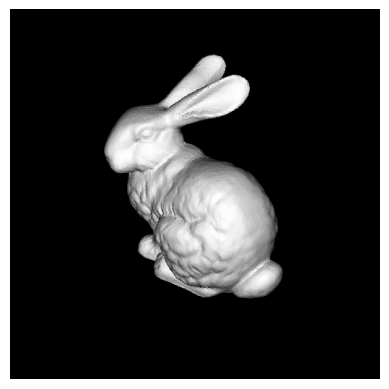

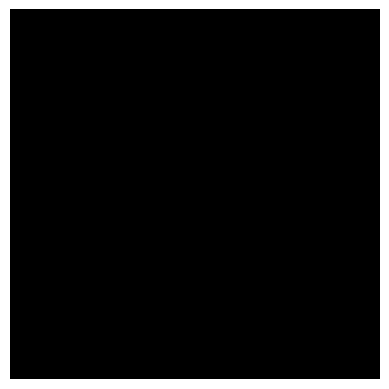

In [6]:
# Render the scene without BVH acceleration
renderer.load_triangles(scene)
renderer.render(
    view_mat=cam.view_matrix(),
    fov=cam.fov,
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

In Jupyter Notebook, you can benchmark a cell by using the `%%timeit` command. Let's benchmark the performance of the naive ray tracer

In [7]:
%%timeit
renderer.render(
    view_mat=cam.view_matrix(),
    fov=cam.fov,
)

511 μs ± 29.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## BVH Construction

To accelerate ray-primitive intersection tests, we will implement the Bounding Volume Hierarchy (BVH) data structure we covered in class. In this section, you will implement the BVH construction algorithm in the `BVH` class constructor located in `src/cs248a_renderer/model/bvh.py`.

Before we jump into the actual implementation, let's walk through some important classes and their properties/functions that will be useful for implementing the BVH construction algorithm.

Let's take a look at the primitive first. The primitive you'll use in this assignment is the `Triangle` class defined in `src/cs248a_renderer/model/mesh.py`

In [8]:
from cs248a_renderer.model.mesh import Triangle
from cs248a_renderer.model.bounding_box import BoundingBox3D

tri1 = Triangle(
    vertices=[
        glm.vec3(0.0, 0.0, 0.0),
        glm.vec3(1.0, 0.0, 0.0),
        glm.vec3(0.0, 1.0, 1.0),
    ]
)
tri2 = Triangle(
    vertices=[
        glm.vec3(1.0, 1.0, 1.0),
        glm.vec3(2.0, 1.0, 1.0),
        glm.vec3(1.0, 2.0, 2.0),
    ]
)
tri1, tri2

(Triangle(vertices=[vec3( 0, 0, 0 ), vec3( 1, 0, 0 ), vec3( 0, 1, 1 )], colors=[vec3( 1, 0, 1 ), vec3( 1, 0, 1 ), vec3( 1, 0, 1 )]),
 Triangle(vertices=[vec3( 1, 1, 1 ), vec3( 2, 1, 1 ), vec3( 1, 2, 2 )], colors=[vec3( 1, 0, 1 ), vec3( 1, 0, 1 ), vec3( 1, 0, 1 )]))

As defined in `src/cs248a_renderer/model/primitive.py`, all the primitives should implement the `bounding_box` property. Now, read the `BoundingBox3D` class defined in `src/cs248a_renderer/model/bounding_box.py`. See how you can get the center, surface area, and union of bounding boxes. These properties/functions will be useful when you implement the BVH construction algorithm.

In [9]:
# Let's get the bounding boxes of the triangles
bb1 = tri1.bounding_box
bb2 = tri2.bounding_box
bb1, bb2

(BoundingBox3D(min=vec3( 0, 0, 0 ), max=vec3( 1, 1, 1 )),
 BoundingBox3D(min=vec3( 1, 1, 1 ), max=vec3( 2, 2, 2 )))

In [10]:
# Let's find the center and surface area of the bounding boxes
center1 = bb1.center
center2 = bb2.center
area1 = bb1.area
area2 = bb2.area
center1, center2, area1, area2

(vec3( 0.5, 0.5, 0.5 ), vec3( 1.5, 1.5, 1.5 ), 6.0, 6.0)

In [11]:
# What about the union of two bounding boxes?
bb_union = BoundingBox3D.union(bb1, bb2)
bb_union

BoundingBox3D(min=vec3( 0, 0, 0 ), max=vec3( 2, 2, 2 ))

### Building the BVH

Now, let's walk through the specification of the `BVH` class and its constructor.

The `BVH` constructor takes in the following parameters:

- `primitives`: A list of primitives (e.g., triangles) to be included in the BVH.
- `max_nodes`: The maximum number of BVH nodes allowed in the hierarchy. For example, if you construct a perfectly balanced BVH with 15 nodes, it can contain up to 8 leaf nodes.
- `min_prim_per_node`: When constructing the BVH, instead of keeping the tree perfectly balanced, a more preferred feature is to have roughly the same number of primitives in each leaf node. `min_prim_per_node` specifies the minimum number of primitives that should be stored in each leaf node. If a node contains fewer than `min_prim_per_node` primitives, it should not be split further.
- `num_thresholds`: When we split a node, we need to decide where to split it. In this assignment, we will use the Surface Area Heuristic (SAH) to determine the best split. To do this, we will evaluate a number of potential split positions along each axis. `num_thresholds` specifies how many potential split positions to evaluate along each axis. The more thresholds you evaluate, the better the split will be, but it will also increase the construction time.
- `on_progress`: This is just a callback function that you can use to report progress during BVH construction. You should call this function and pass in the current number of nodes and the maximum number of nodes whenever you make progress in constructing the BVH.

A importnat note about the `primitives` list is that the BVH constructor will be responsible for reordering the primitives in this list according to the BVH structure. After the BVH is constructed, the primitives in the leaf nodes should be stored contiguously in this list.

For example, if the BVH has 3 leaf nodes, and the first leaf node contains 2 primitives, the second leaf node contains 3 primitives, and the third leaf node contains 1 primitive, then after construction, the `primitives` list should be reordered such that the first 2 primitives belong to the first leaf node, the next 3 primitives belong to the second leaf node, and the last primitive belongs to the third leaf node.

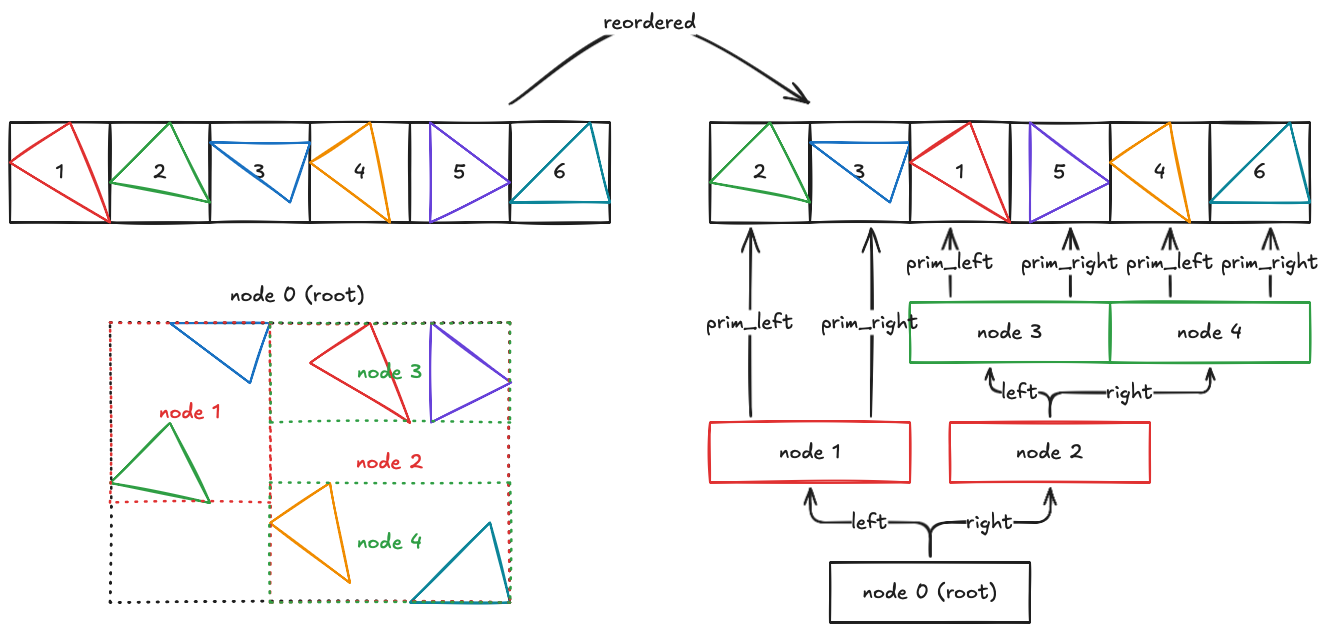

Your task is to implement the `BVH` constructor to build the BVH and reorder the `primitives` list accordingly.

In [12]:
MAX_NODES = 2048
triangles = scene.extract_triangles()
tqdm_bar = tqdm(total=MAX_NODES)
def on_progress(current: int, total: int) -> None:
    tqdm_bar.n = current
    tqdm_bar.refresh()
bvh = BVH(
    primitives=triangles,
    max_nodes=MAX_NODES,
    on_progress=on_progress
)

  0%|          | 0/2048 [00:00<?, ?it/s]

To visualize the BVH you constructed, you can run the following cell to render all the bounding boxes in a certain depth.

Change the `depth` parameter passed into the `visualizeBVH` function to visualize different levels of the BVH.

If your BVH is constructed correctly, you should see something like this when visualizing depth 5:

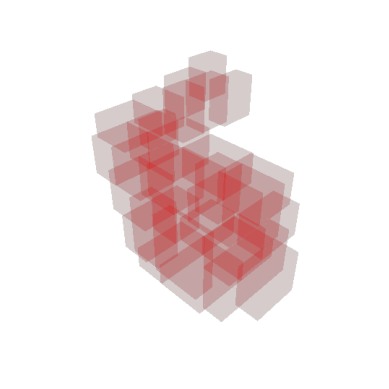

And like this when visualizing depth 10:

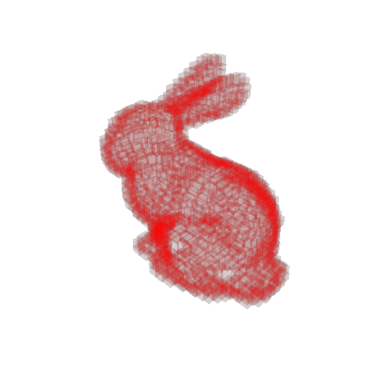

Note that the BVH you constructed may look slightly different depending on how you split the nodes, but the overall structure should be similar.

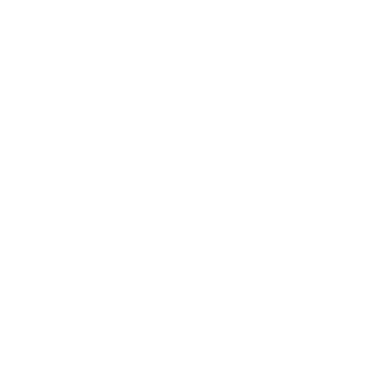

In [13]:
BVH_IMG_SIZE = (512, 512)
bvh_image = device.create_texture(
    type=spy.TextureType.texture_2d,
    format=spy.Format.rgba32_float,
    usage=spy.TextureUsage.unordered_access,
    width=BVH_IMG_SIZE[0],
    height=BVH_IMG_SIZE[1],
)
bvh_node_buf = create_bvh_node_buf(renderer_modules.model_module, bvh.nodes)
bvh_visualizer_module.visualizeBVH(
    tid=spy.grid(shape=BVH_IMG_SIZE),
    camera = {
        "invViewMatrix" : np.ascontiguousarray(
            glm.inverse(cam.view_matrix()), dtype=np.float32
        ),
        "canvasSize": list(BVH_IMG_SIZE),
        "focalLength": float(cam.focal_length(BVH_IMG_SIZE[1]))
    },
    nodes = bvh_node_buf,
    numNodes = len(bvh.nodes),
    depth = 10,
    alpha = 0.2,
    _result=bvh_image
)
plt.imshow(np.flipud(bvh_image.to_numpy()))
plt.axis('off')
plt.show()

## Ray Tracing with BVH

Now that you've implemented the BVH construction algorithm, it's time to use the BVH to accelerate ray-primitive intersection tests in the ray tracer.

The `renderer.load_bvh` method will load the `BVHNode` list from Python to a Slang buffer.

In [14]:
renderer.load_bvh(triangles=triangles, bvh=bvh)

Your task is to implement the `hit` method of the `BVH` struct in `src/cs248a_renderer/slang_shaders/model/bvh.slang`. This method should traverse the BVH and test for intersections between the ray and the primitives in the leaf nodes it hits.

Now, in the `sample` function from `src/cs248a_renderer/slang_shaders/renderer.slang`, use the BVH `hit` method to perform ray-primitive intersection tests instead of testing against all primitives if `uniforms.useBVH` is true.

Once you've implemented the BVH traversal algorithm correctly, you should run the following cell and get the same rendering result as before, but with significantly improved performance.

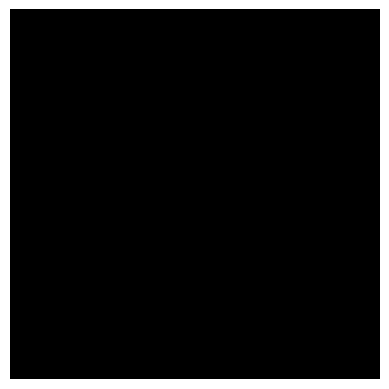

In [15]:
renderer.render(
    view_mat=cam.view_matrix(),
    fov=cam.fov,
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

Let's benchmark the performance of the ray tracer with BVH acceleration. What's the speedup compared to the naive ray tracer you implemented in part 1?

In [16]:
%%timeit
renderer.render(
    view_mat=cam.view_matrix(),
    fov=cam.fov,
)

506 μs ± 3.65 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
